# Data Analysis

## Setup

In [1]:
import os
import sys
from os.path import join, exists, expanduser
from datetime import datetime

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import git
import time

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red_sea_monitoring"))

from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format, percent_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

In [2]:
df = pd.read_parquet(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v5.parquet'))
len(df)

1761090

In [3]:
df.arrival_dt_pos_utc = pd.to_datetime(df.arrival_dt_pos_utc)

In [4]:
df = df.loc[df.arrival_dt_pos_utc>="2023-02-01"].copy()
df_ref = df.loc[df.arrival_dt_pos_utc<'2023-10-01'].copy()

In [5]:
# df = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'G_sea_routes_edges.csv'), index_col=0)
# df.head(10).to_csv(join(expanduser("~"), 'tmp', 'ais', 'G_sea_routes_edges_sample.csv'))

## Get Vessels that crossed Red Sea in Reference Period

In [6]:
aois = ['Bab el-Mandeb Strait', 'Suez Canal']

In [7]:
df_sel = df.loc[(df.prev_port.isin(aois)) | (df.Port.isin(aois))].copy()

In [8]:
unique_vessels_red_sea = list(set(df_sel.unique_id))
unique_vessels = list(set(df.unique_id))
len(unique_vessels_red_sea) / len(unique_vessels)

0.1230031095391257

In [9]:
df2 = df.loc[df.unique_id.isin(unique_vessels_red_sea)].copy()

In [10]:
len(df2) / len(df)

0.1564102395245071

Select only Cargo and Tanker for reporting

In [11]:
# df2.vessel_type.value_counts()

In [12]:
types_sel = ['Cargo', 'Tanker']
df2 = df2[df2['vessel_type'].isin(types_sel)].copy()

In [13]:
len(df2) / len(df)

0.1481514963022742

Filter out short trips

In [14]:
df2 = df2.loc[df2.time_travel>1].copy()

In [15]:
df2.loc[:, "ymd"] = df2.apply(lambda x: datetime(year=x['year'], month=x['month'], day=1), axis=1)

In [16]:
df_cape = df2.loc[(df2.Port=='Cape of Good Hope') | (df2.prev_port=='Cape of Good Hope')].copy()
df_bab = df2.loc[(df2.Port=='Bab el-Mandeb Strait') | (df2.prev_port=='Bab el-Mandeb Strait')].copy()
df3 = pd.concat([df_cape, df_bab])
df3.reset_index(drop=False, inplace=True)
df3 = df3.loc[~df3.duplicated(subset='index')].copy()
group_cols = ['ymd', 'vessel_type']
data_cols = ['time_travel', 'distance']
df_agg = df3.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_cape = df_cape.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_bab = df_bab.groupby(group_cols)[data_cols].sum().reset_index()

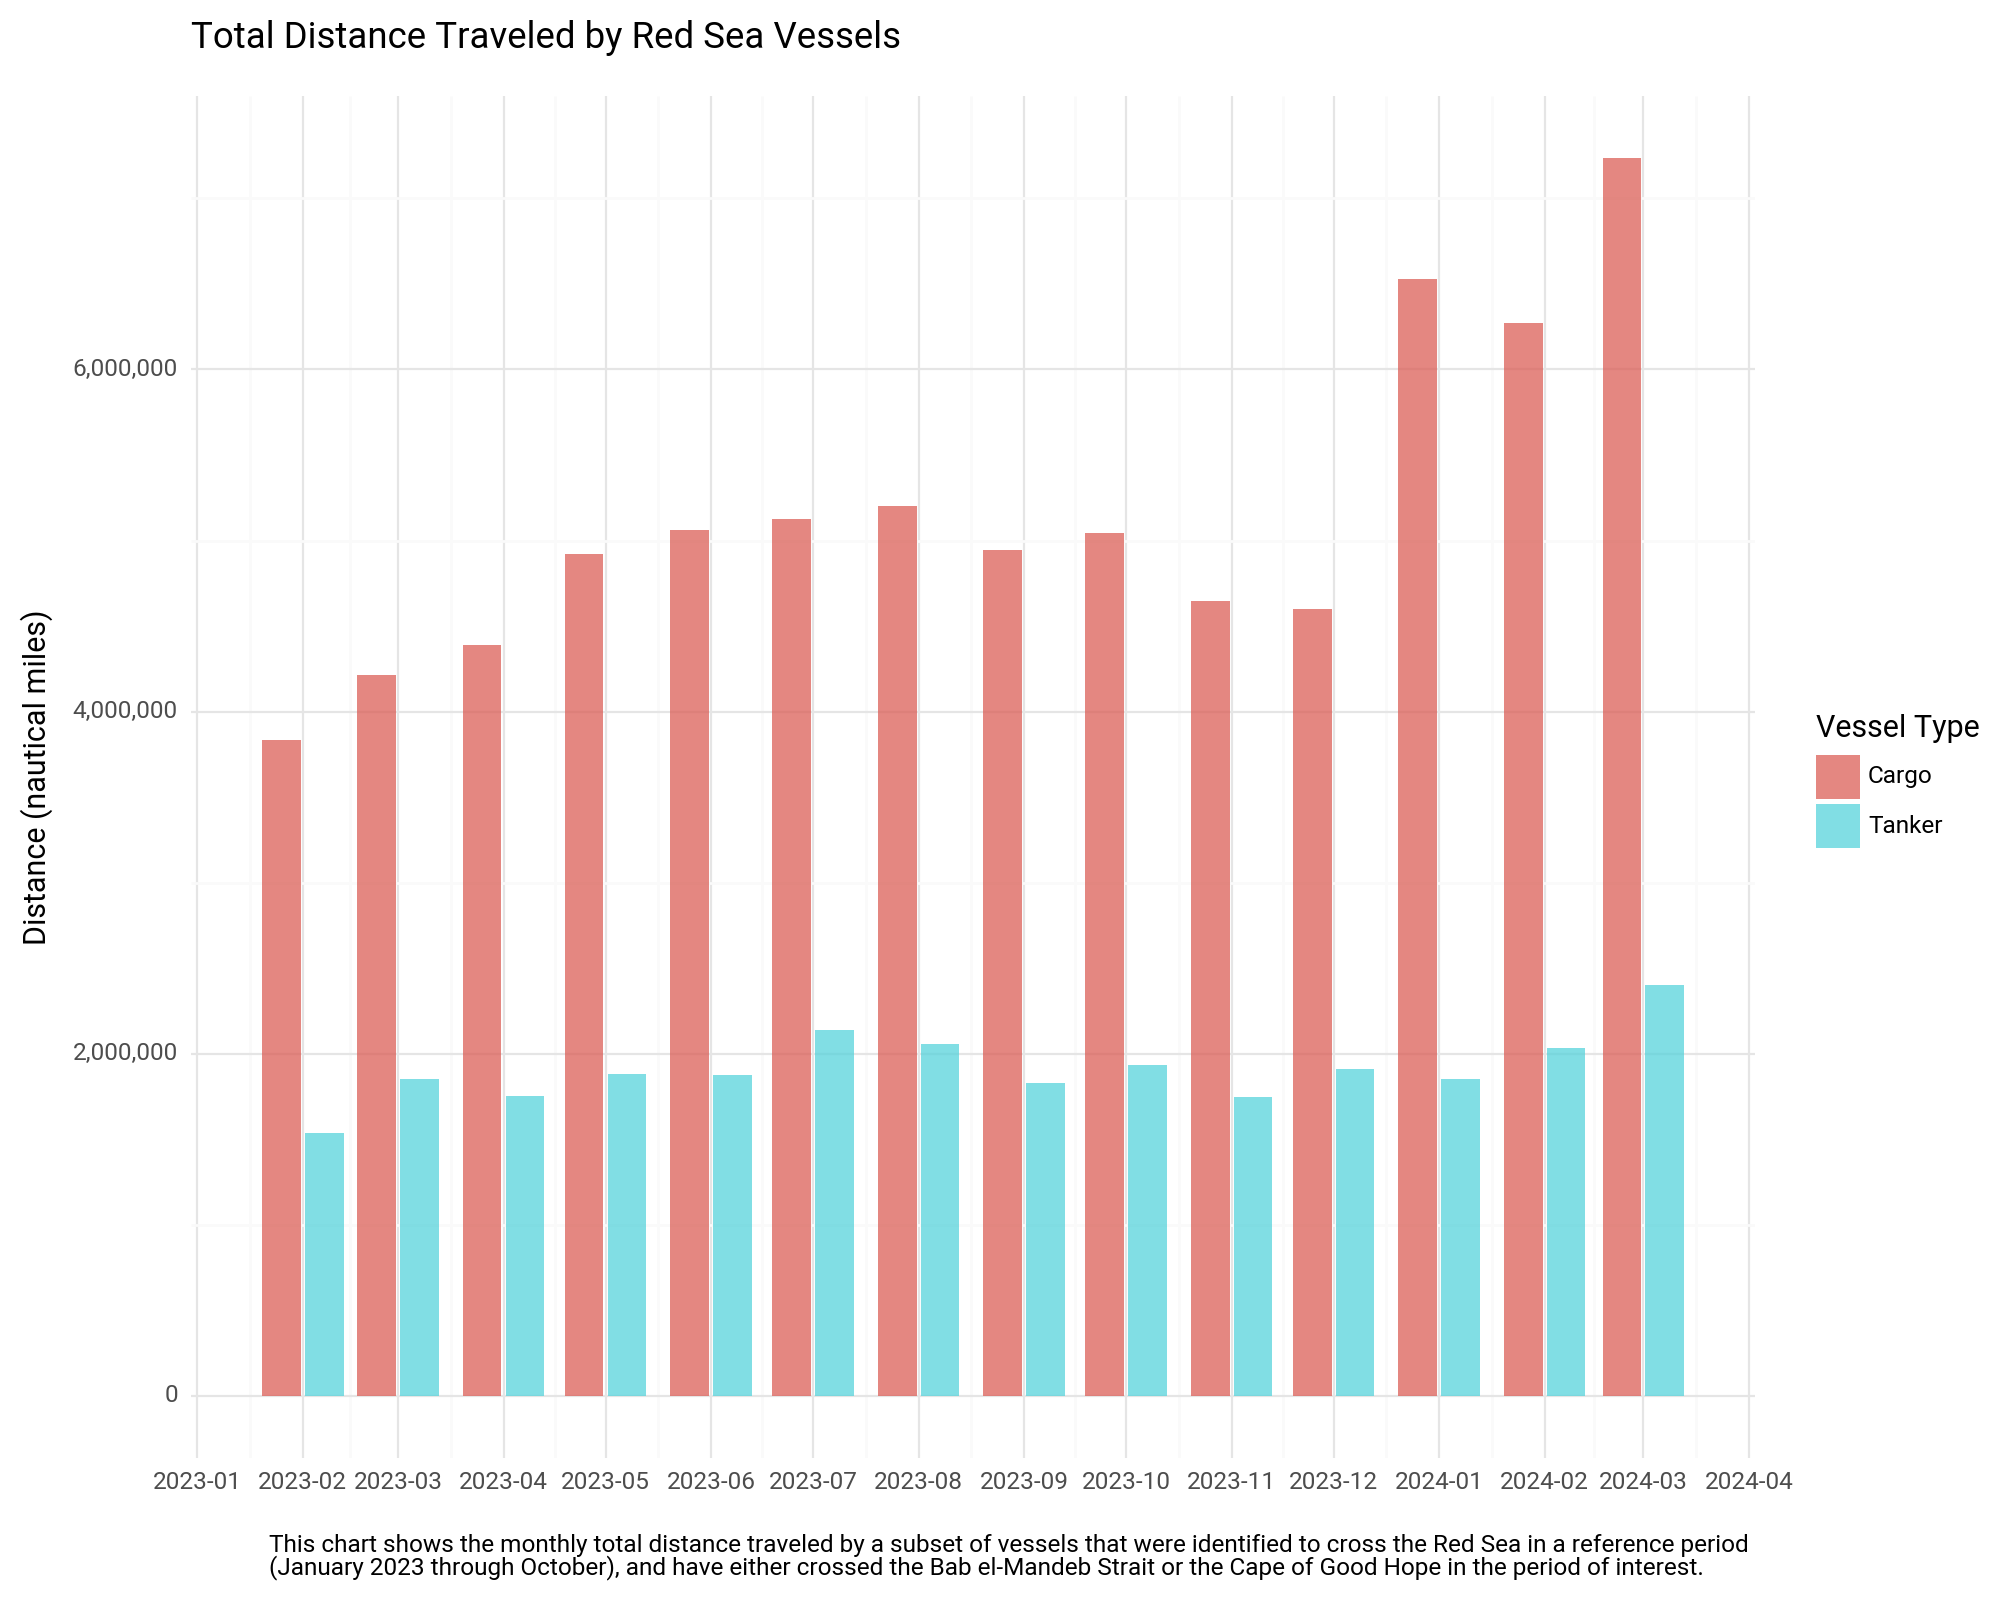

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled.jpeg


In [17]:
p0 = (
    ggplot(df_agg, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (nautical miles)",
        title=f"Total Distance Traveled by Red Sea Vessels",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have either crossed the Bab el-Mandeb Strait or the Cape of Good Hope in the period of interest.",
        fill="Vessel Type"
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="right")
)
display(p0)
p0.save(
    filename=join(charts_dir, 'routes', f"distance-traveled.jpeg"), dpi=300
)

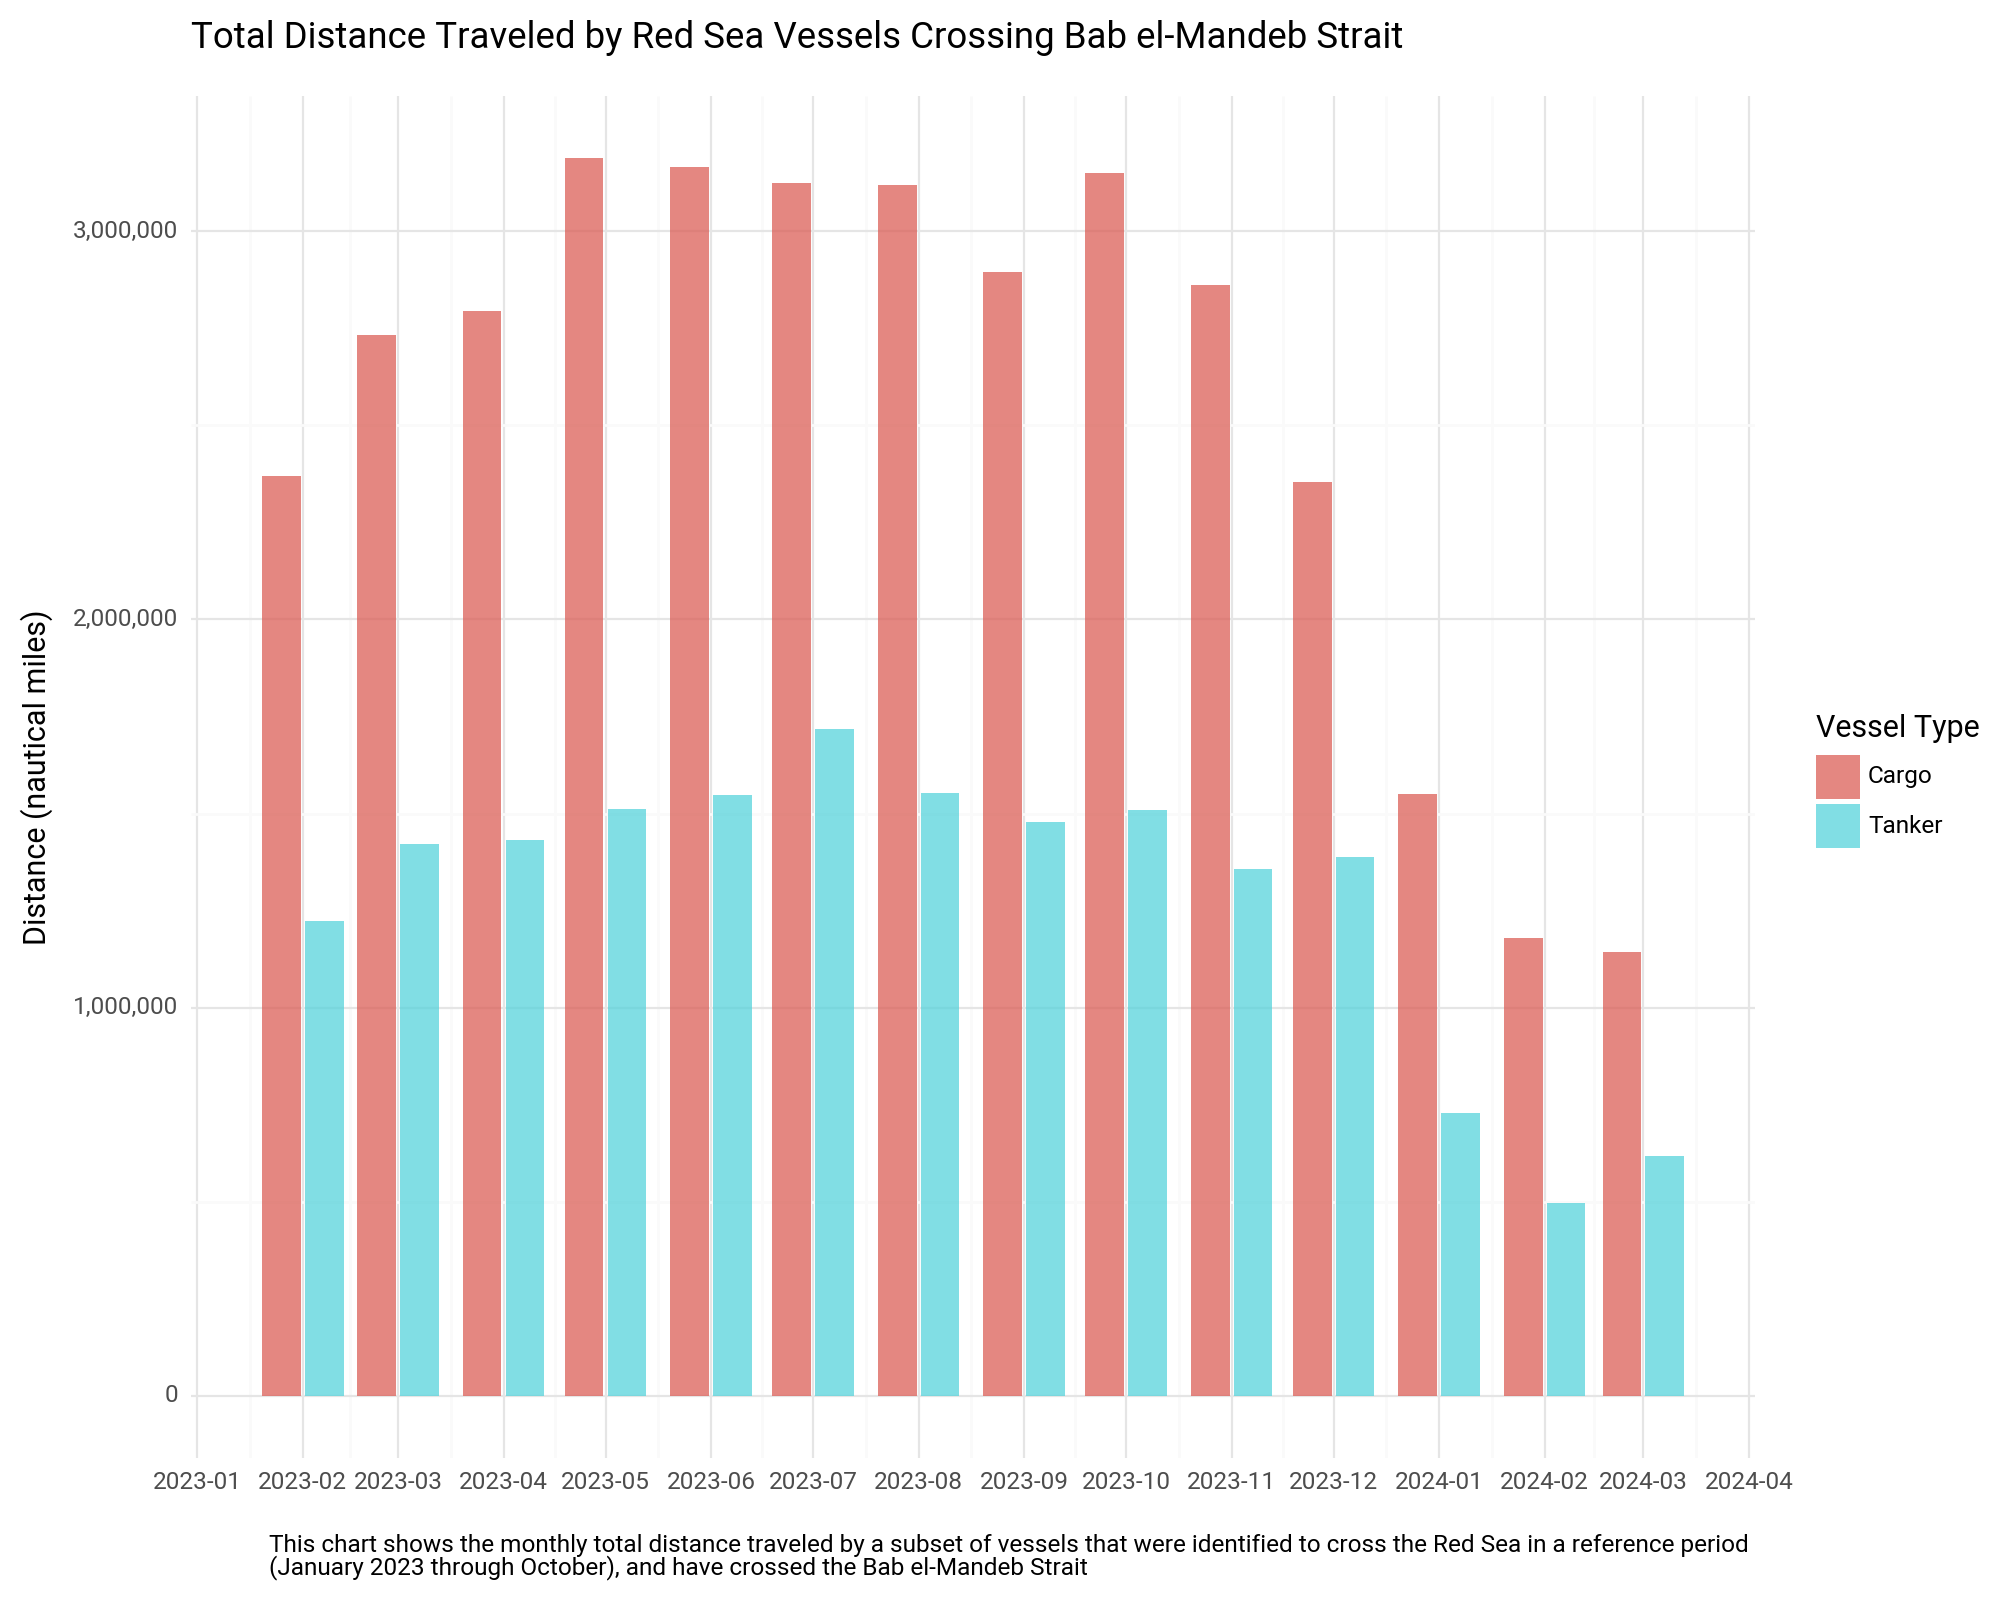

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-bab.jpeg


In [18]:
p1 = (
    ggplot(df_agg_bab, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (nautical miles)",
        fill="Vessel Type",
        title=f"Total Distance Traveled by Red Sea Vessels Crossing Bab el-Mandeb Strait",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Bab el-Mandeb Strait",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="right")
)
display(p1)
p1.save(
    filename=join(charts_dir, 'routes', f"distance-traveled-bab.jpeg"), dpi=300
)

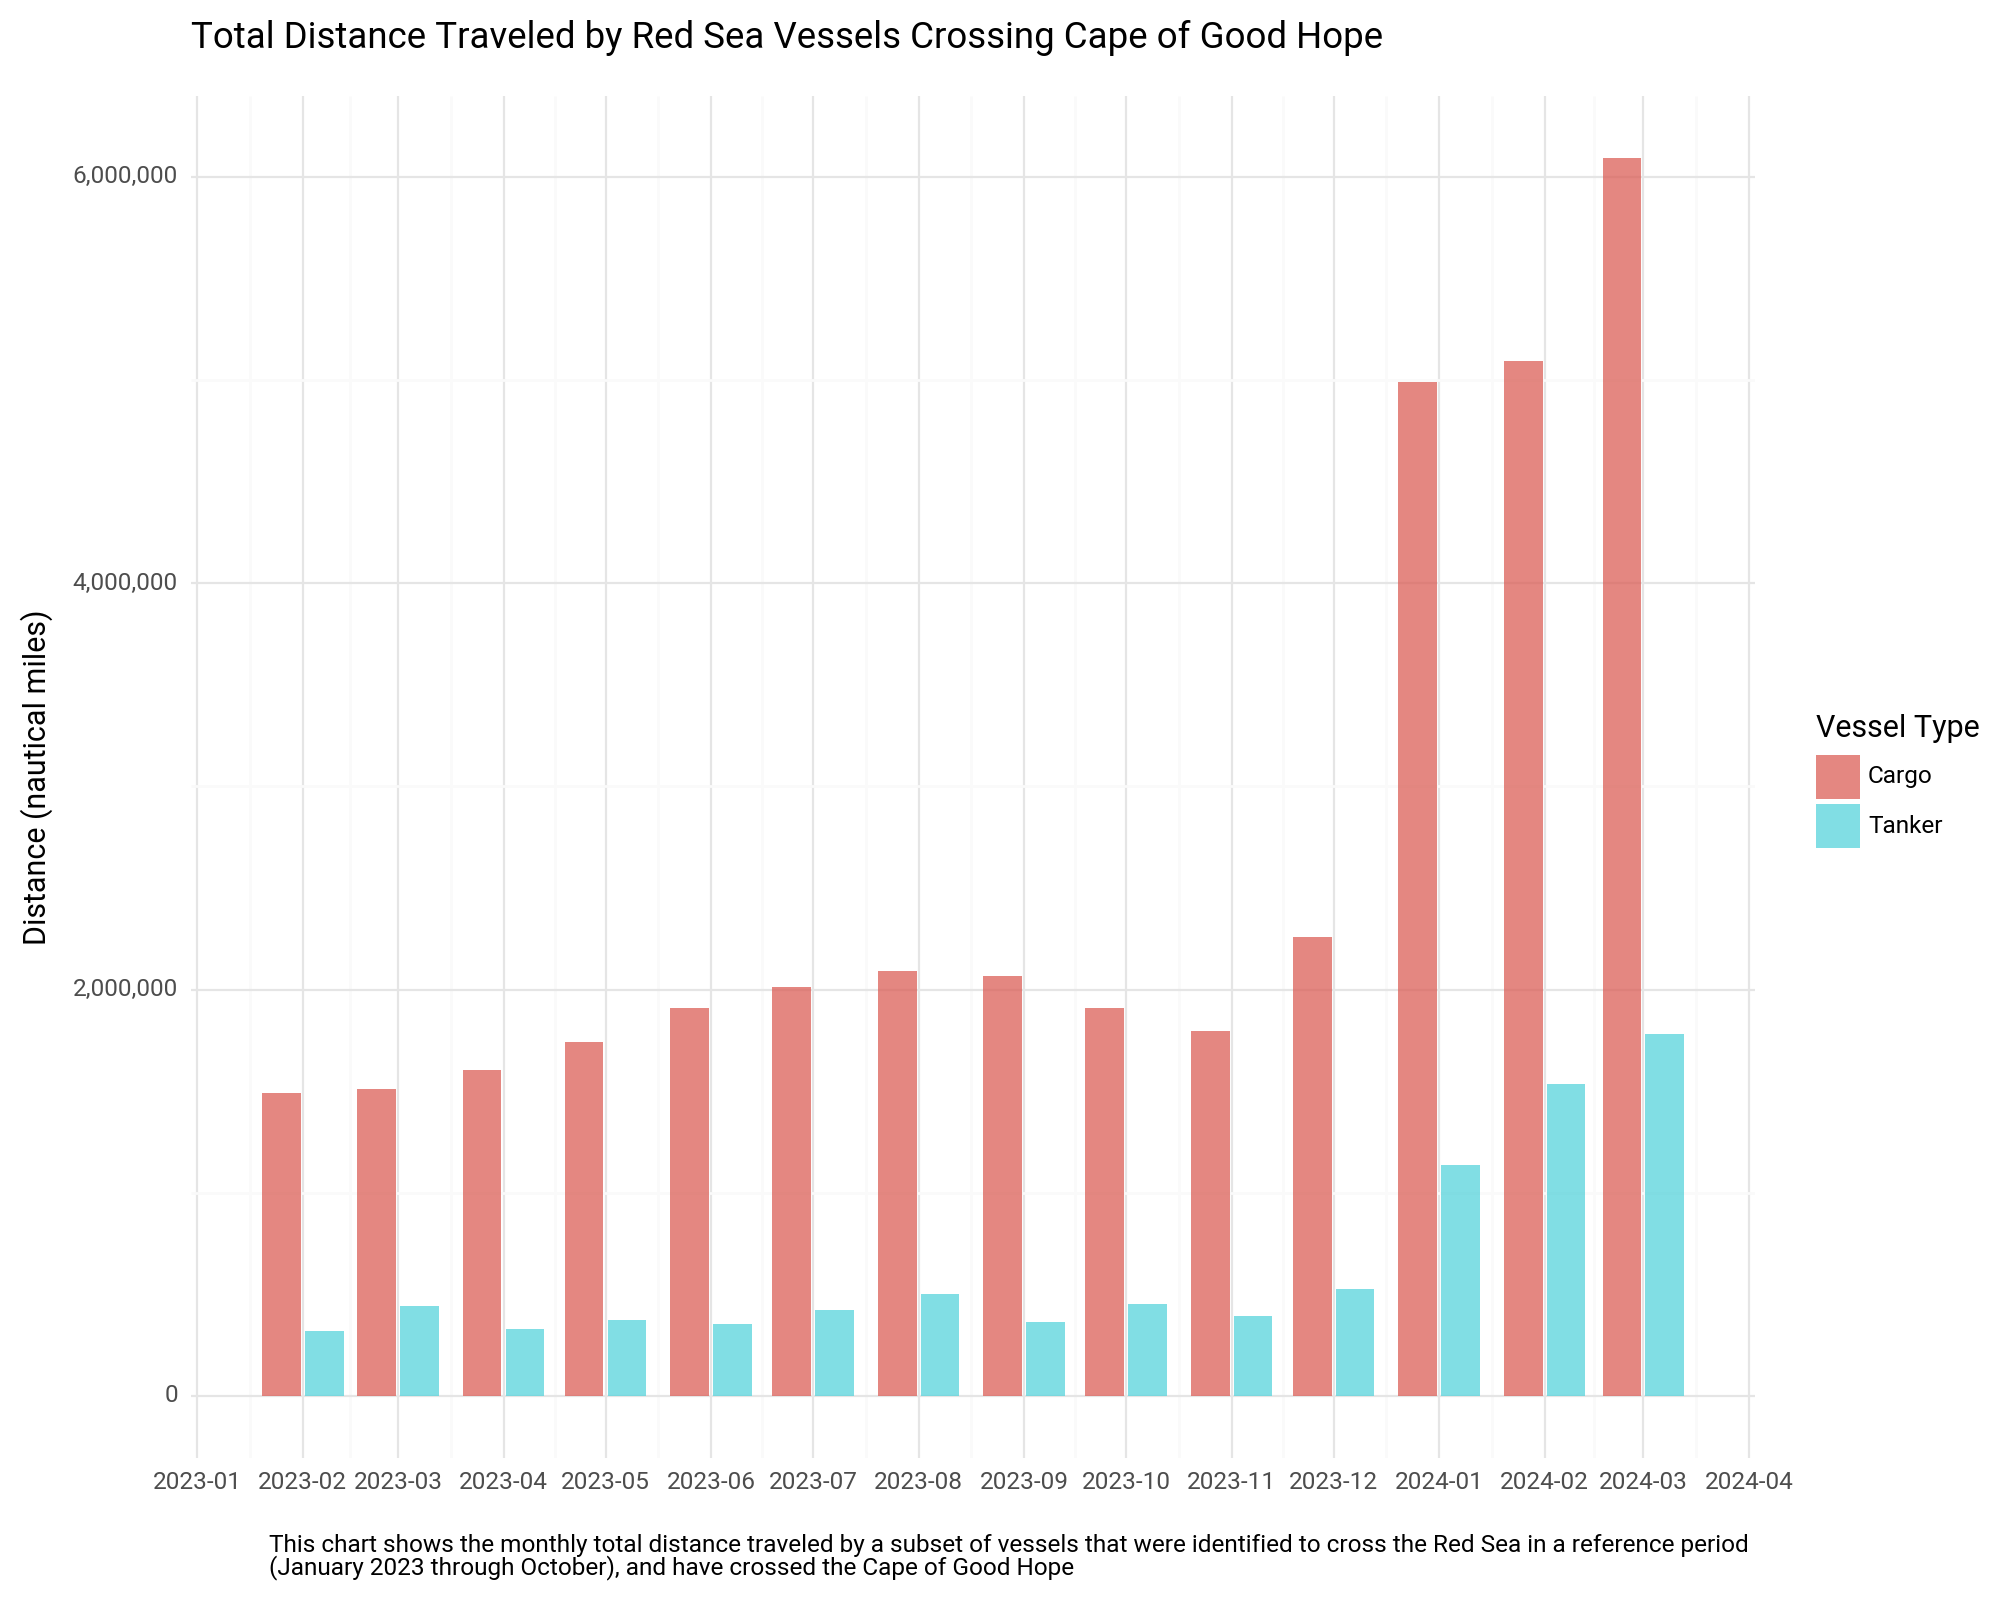

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-cape.jpeg


In [19]:
p3 = (
    ggplot(df_agg_cape, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (nautical miles)",
        fill="Vessel Type",
        title=f"Total Distance Traveled by Red Sea Vessels Crossing Cape of Good Hope",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(legend_position="right")
)
display(p3)
p3.save(
    filename=join(charts_dir, 'routes', f"distance-traveled-cape.jpeg"), dpi=300
)

## Data Table

In [23]:
group_cols = ['year', 'month', 'vessel_type', 'Country', 'Port', 'prev_country', 'prev_port']
data_cols = ['time_travel', 'distance']
df_agg_od = df3.groupby(group_cols).aggregate({
    'time_travel': 'sum', 
    'distance': 'sum', 
    'unique_id': 'count'
}).reset_index()
df_agg_od.rename(columns={
    'unique_id': 'No. of Vessels',
    'prev_port': 'Previous Port',
    'prev_country': 'Previous Country',
    'vessel_type': 'Vessel Type',
    'time_travel': 'Total travel time (hrs.)',
    'distance': 'Total distance (n. miles)',
    'count_routes': 'No. of Vessels'
    }, inplace=True)
df_agg_od = df_agg_od[['year', 'month', 'Vessel Type', 'Previous Port', 'Previous Country', 'Country', 'Port', 'Total travel time (hrs.)', 'Total distance (n. miles)', 'No. of Vessels']].copy()

In [24]:
df_agg_od.head()

,year,month,Vessel Type,Previous Port,Previous Country,Country,Port,Total travel time (hrs.),Total distance (n. miles),No. of Vessels
0,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Angola,Luanda,338.479167,4844.855522,3
1,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Campana,1284.538333,7704.478373,2
2,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Puerto Ingeniero White,435.671389,4088.880729,1
3,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Rosario,2431.078889,23643.129837,6
4,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,San Nicolas,915.360000,7837.098024,2


In [25]:
print(df_agg_od.head().to_markdown())

|    |   year |   month | Vessel Type   | Previous Port     | Previous Country             | Country   | Port                   |   Total travel time (hrs.) |   Total distance (n. miles) |   No. of Vessels |
|---:|-------:|--------:|:--------------|:------------------|:-----------------------------|:----------|:-----------------------|---------------------------:|----------------------------:|-----------------:|
|  0 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Angola    | Luanda                 |                    338.479 |                     4844.86 |                3 |
|  1 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Campana                |                   1284.54  |                     7704.48 |                2 |
|  2 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Puerto Ingeniero White |                    435.671 |          

In [26]:
df_agg_od.to_csv(join(output_dir, 'tables', 'red-sea-distance-summary.csv'), index=False)

## Calculate % Change from Baseline

In [24]:
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [25]:
df_baseline = df_agg.loc[df_agg.ymd<'2023-10-01'].copy()

In [26]:
df_baseline = df_baseline.groupby(['vessel_type'])[['time_travel', 'distance']].mean()

In [27]:
df_baseline.reset_index(inplace=True)

In [28]:
df_baseline.rename(columns={
    'time_travel': 'time_travel_ref',
    'distance': 'distance_ref'
}, inplace=True)

In [58]:
df_crisis = df_agg.loc[df_agg.ymd>='2023-10-01'].copy()

In [59]:
df_crisis = df_crisis.merge(df_baseline, on='vessel_type', how='left')

In [60]:
df_crisis.loc[:, 'distance_pct'] = (df_crisis.distance - df_crisis.distance_ref) / df_crisis.distance_ref
df_crisis.loc[:, 'time_pct'] = (df_crisis.time_travel - df_crisis.time_travel_ref) / df_crisis.time_travel_ref

In [61]:
# df_crisis = df_crisis.loc[df_crisis.ymd>='2024-01-01'].copy()

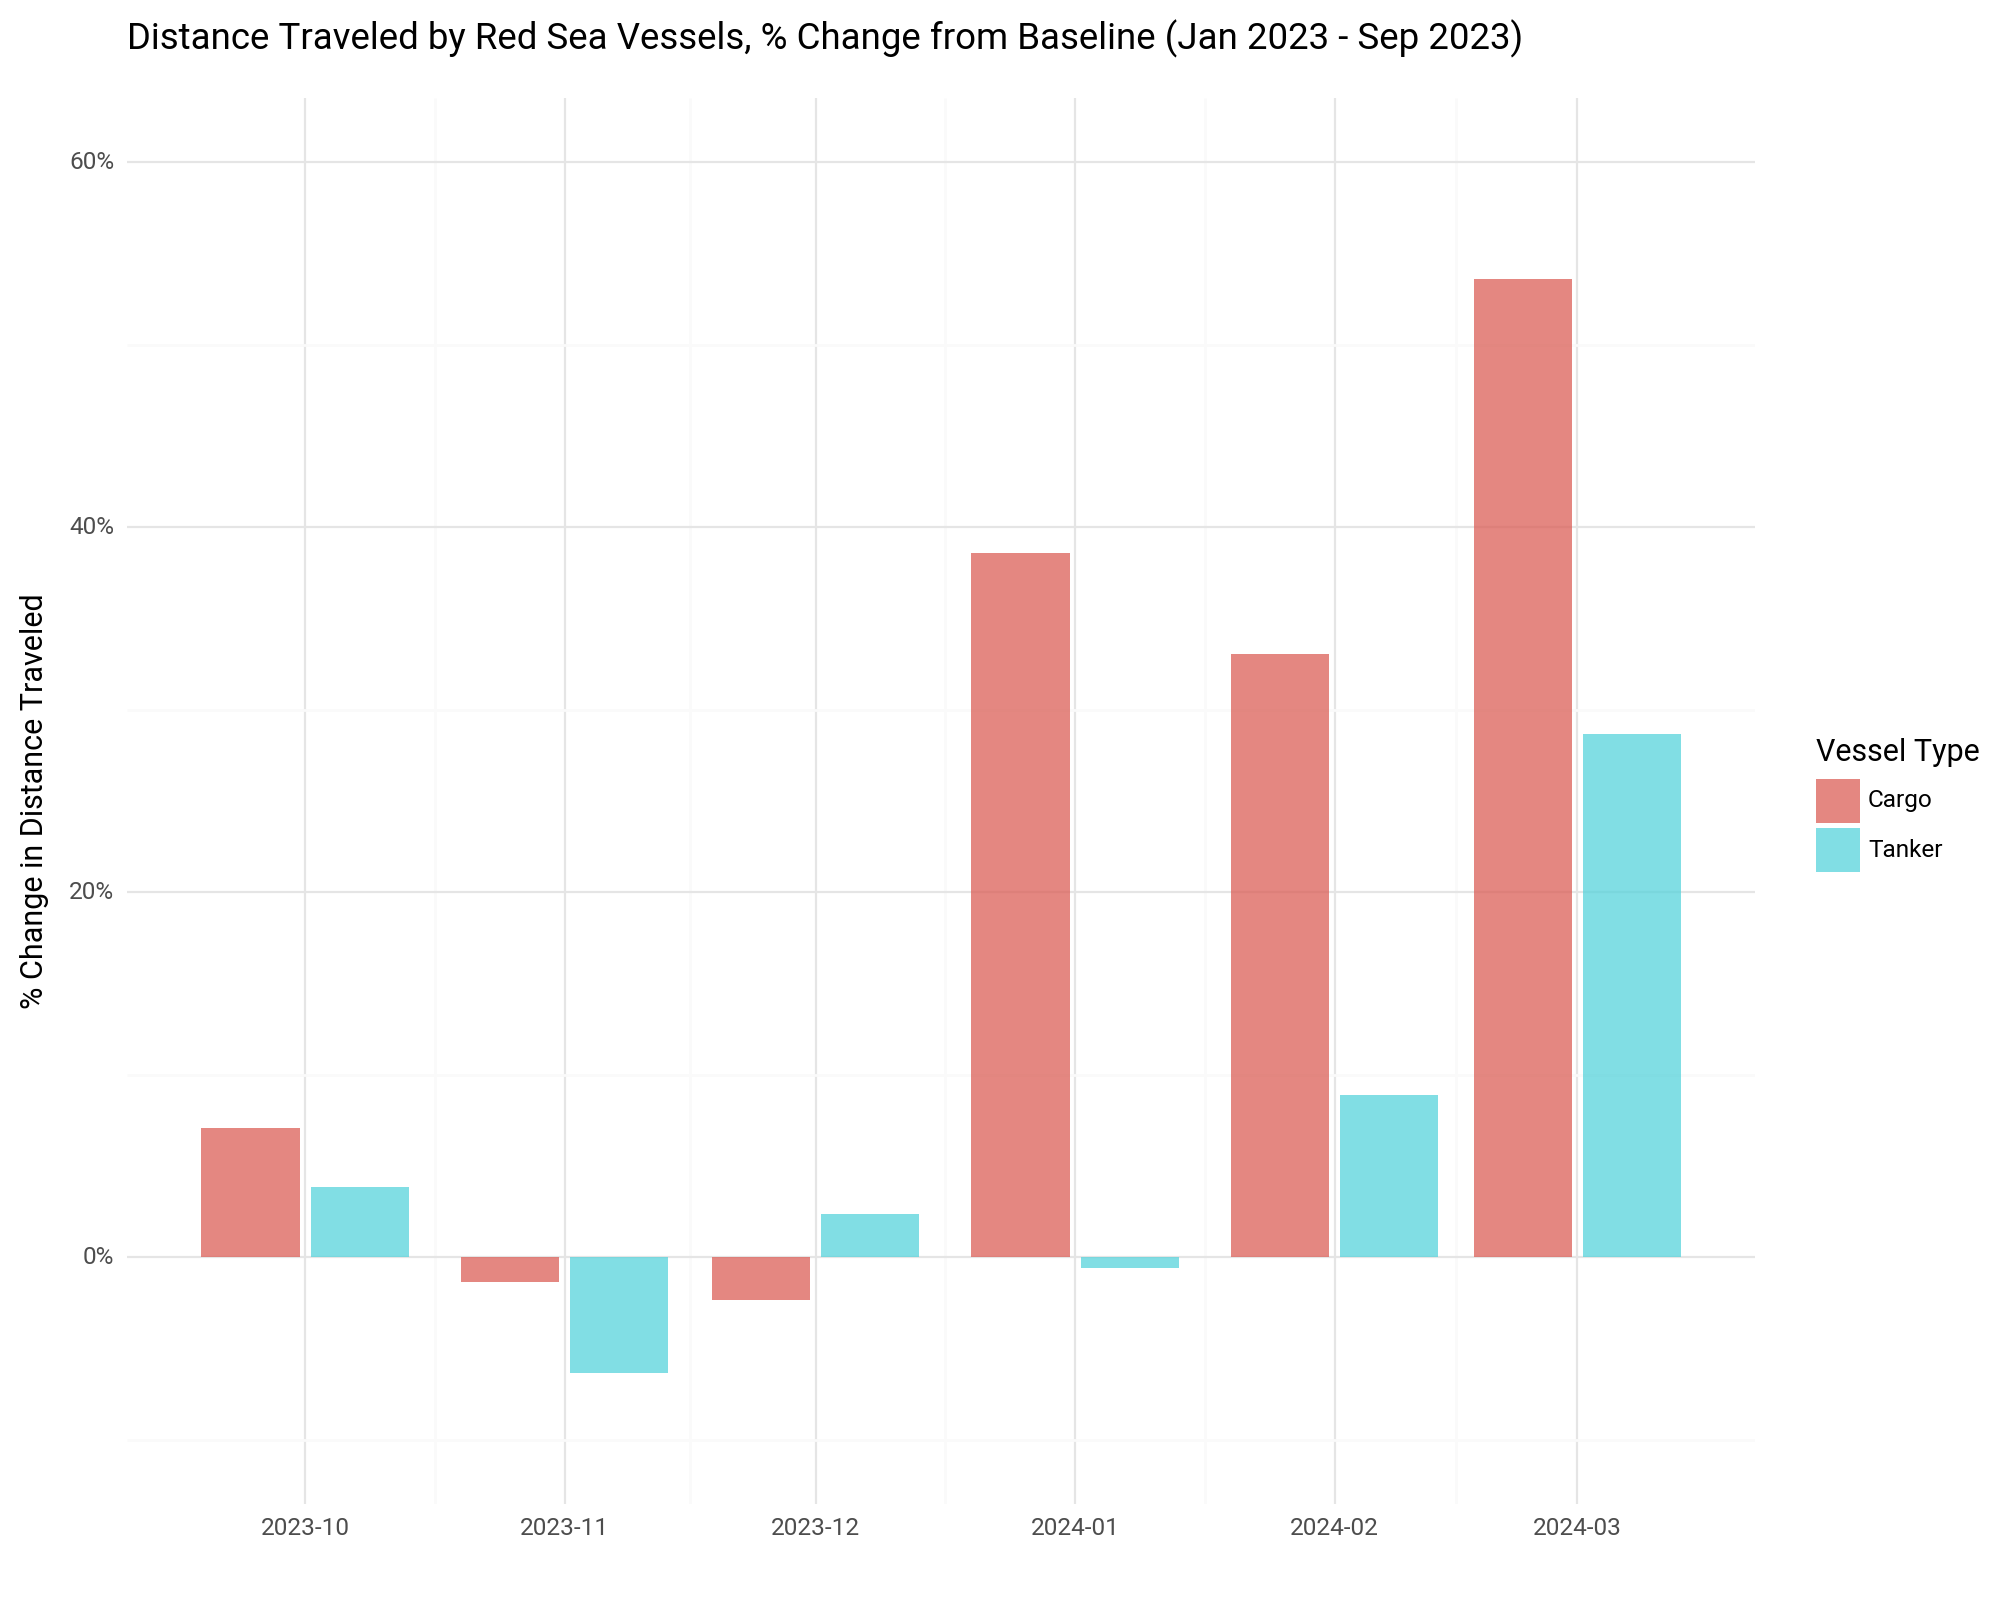

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-pct.jpeg


In [62]:
p4 = (
    ggplot(df_crisis, aes(x="ymd", y="distance_pct", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="% Change in Distance Traveled",
        fill="Vessel Type",
        title=f"Distance Traveled by Red Sea Vessels, % Change from Baseline (Jan 2023 - Sep 2023)",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=percent_format(), limits=(-0.1, 0.6))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(legend_position="right")
)
display(p4)
p4.save(
    filename=join(charts_dir, 'routes', f"distance-traveled-pct.jpeg"), dpi=300
)

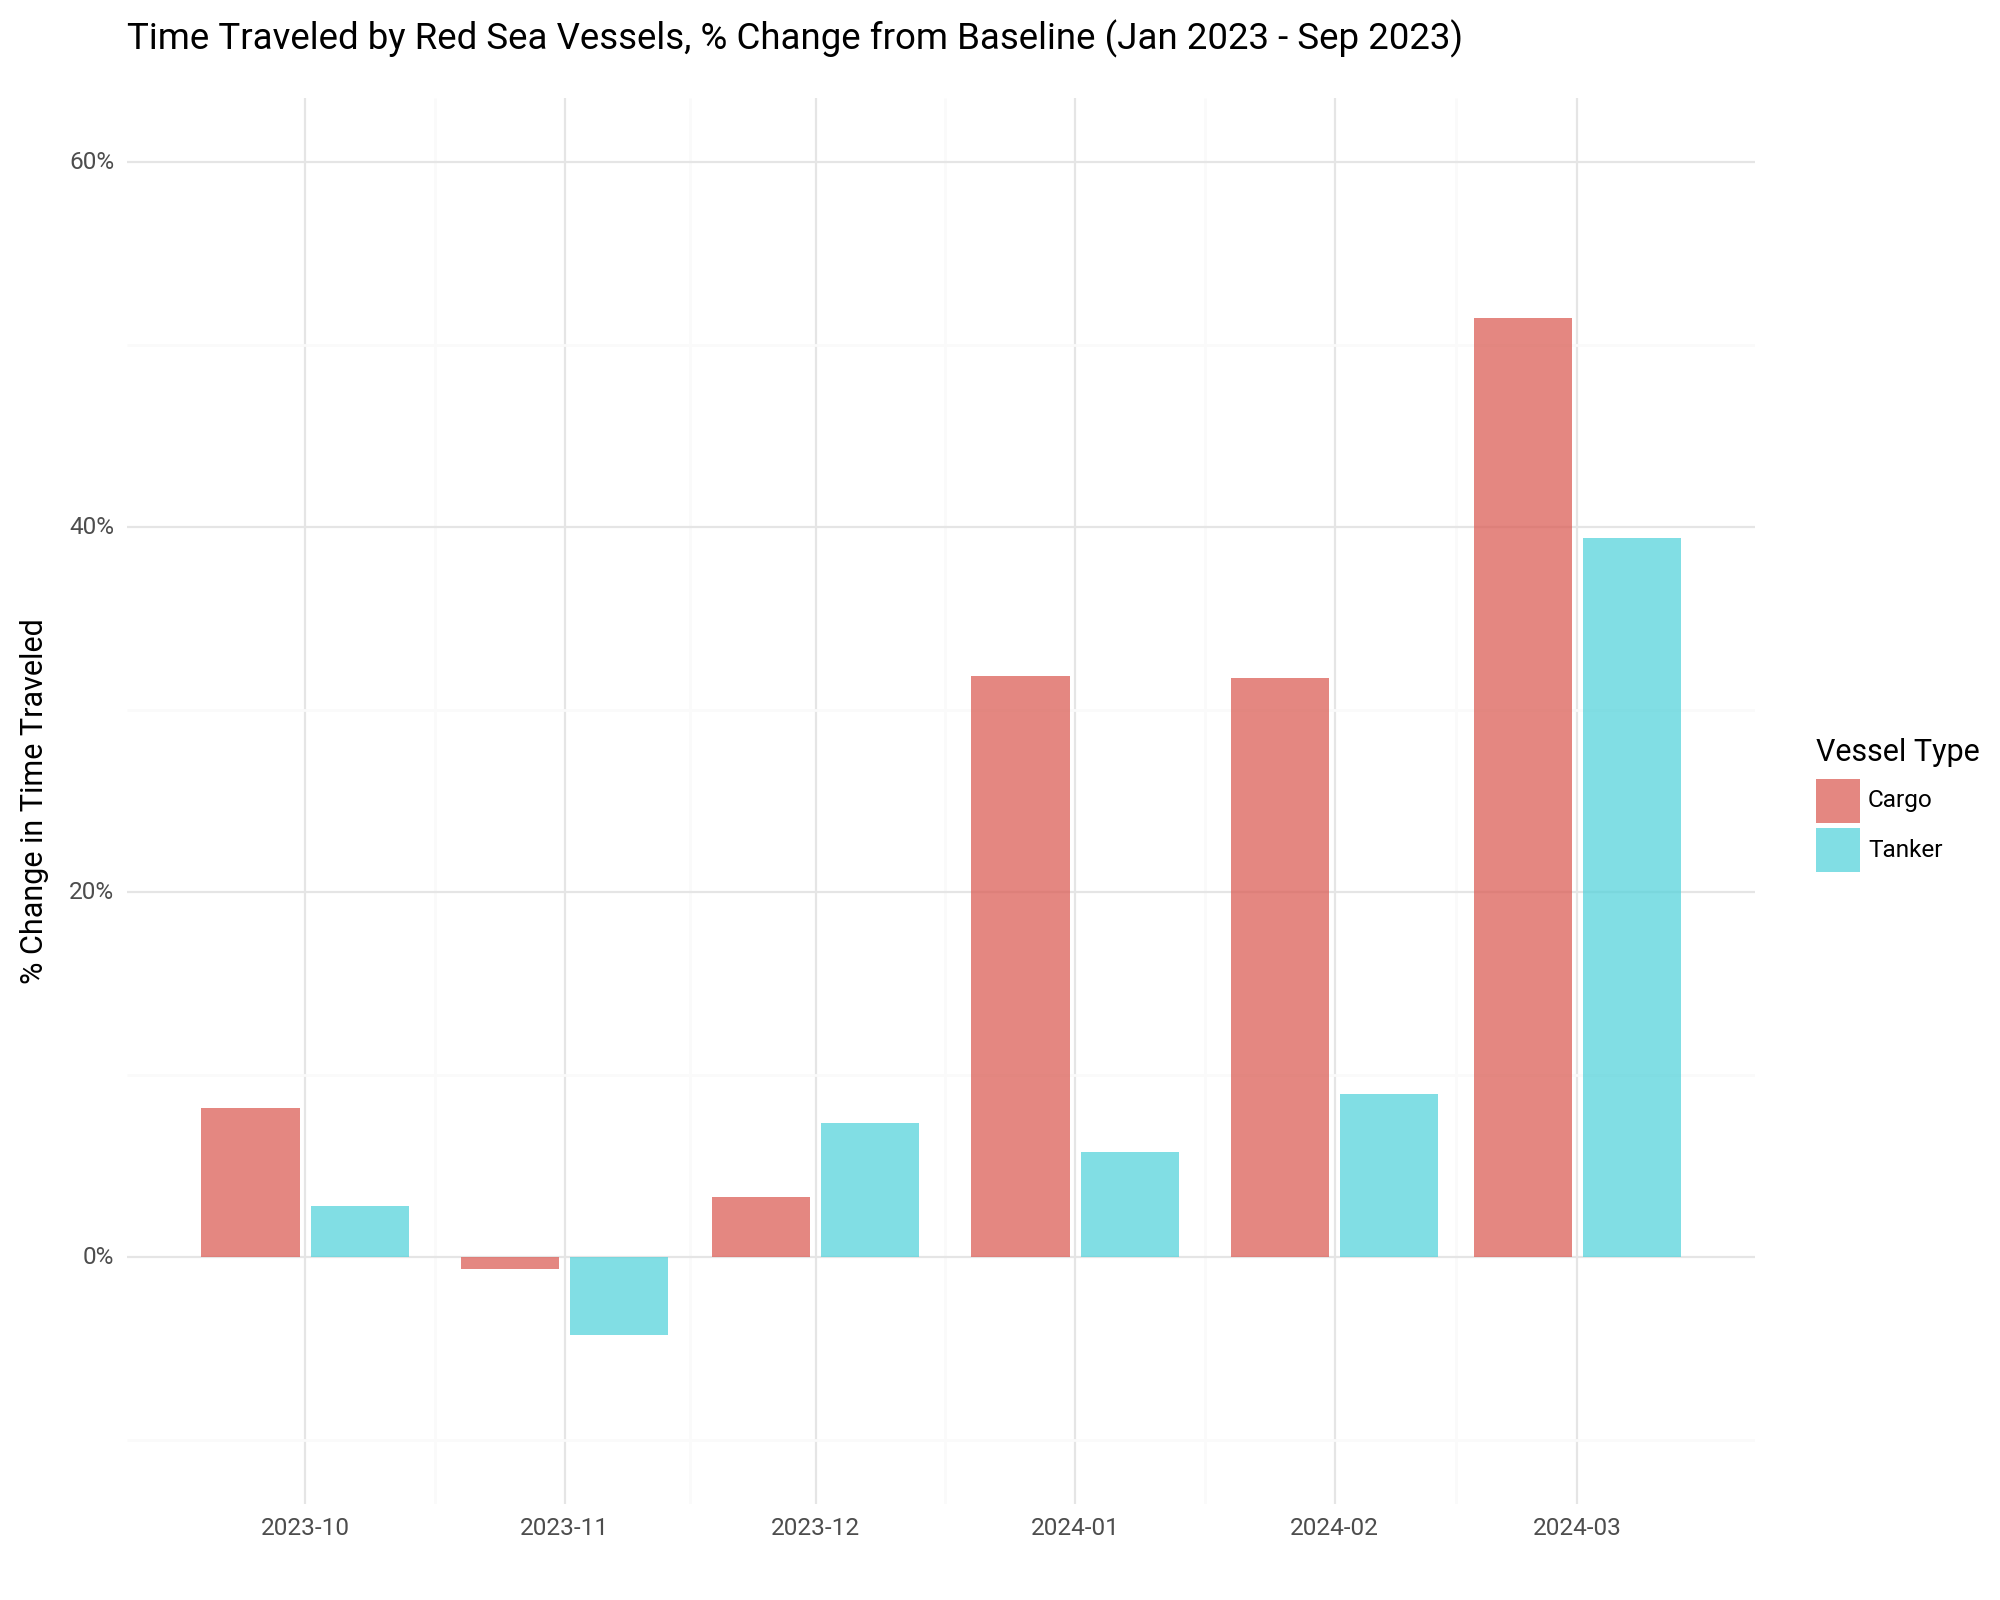

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\time-traveled-pct.jpeg


In [125]:
p5 = (
    ggplot(df_crisis, aes(x="ymd", y="time_pct", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="% Change in Time Traveled",
        fill="Vessel Type",
        title=f"Time Traveled by Red Sea Vessels, % Change from Baseline (Jan 2023 - Sep 2023)",
        # caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period \n(January 2023 through October), and have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=percent_format(), limits=(-0.1, 0.6))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + theme(legend_position="right")
)
display(p5)
p5.save(
    filename=join(charts_dir, 'routes', f"time-traveled-pct.jpeg"), dpi=300
)

In [67]:
df_crisis_sel = df_crisis.loc[df_crisis.ymd>='2024-01-01'].copy()

In [81]:
df_crisis_sel.ymd

6    2024-01-01
7    2024-01-01
8    2024-02-01
9    2024-02-01
10   2024-03-01
11   2024-03-01
Name: ymd, dtype: datetime64[ns]

In [97]:
df_crisis_sel.loc[:, "year_month"] = df_crisis_sel.ymd.dt.strftime("%Y-%m")

In [100]:
pct_table = df_crisis_sel.groupby(['year_month', 'vessel_type'])[['distance_pct', 'time_pct']].mean()#.transpose()

In [102]:
pct_table.reset_index(inplace=True)

In [116]:
cargo_table = pct_table.loc[pct_table.vessel_type=='Cargo'].copy()
tanker_table = pct_table.loc[pct_table.vessel_type=='Tanker'].copy()

cargo_table.drop(columns=['vessel_type'], inplace=True)
tanker_table.drop(columns=['vessel_type'], inplace=True)

In [117]:
cargo_table.set_index('year_month', inplace=True)
tanker_table.set_index('year_month', inplace=True)

cargo_table = cargo_table.transpose()
tanker_table = tanker_table.transpose()

In [120]:
cargo_table.index = ['% Change Distance Travel', '% Change Time Travel']
tanker_table.index = ['% Change Distance Travel', '% Change Time Travel']

In [126]:
cargo_table = cargo_table.applymap(lambda x: f"{x:.1%}")
tanker_table = tanker_table.applymap(lambda x: f"{x:.1%}")

C:\Users\WB514197\AppData\Local\Temp\ipykernel_27332\1012980847.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
C:\Users\WB514197\AppData\Local\Temp\ipykernel_27332\1012980847.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [127]:
print(cargo_table.to_markdown())

|                          | 2024-01   | 2024-02   | 2024-03   |
|:-------------------------|:----------|:----------|:----------|
| % Change Distance Travel | 38.6%     | 33.1%     | 53.6%     |
| % Change Time Travel     | 31.9%     | 31.7%     | 51.5%     |


In [128]:
print(tanker_table.to_markdown())

|                          | 2024-01   | 2024-02   | 2024-03   |
|:-------------------------|:----------|:----------|:----------|
| % Change Distance Travel | -0.6%     | 8.9%      | 28.7%     |
| % Change Time Travel     | 5.8%      | 9.0%      | 39.4%     |


## OECD Data

In [192]:
# df = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'OECD.SDD.NAD.SEEA,DSD_MARITIME_TRANSPORT@DF_MARITIME_TRANSPORT,1.0+all.csv'))
df = pd.read_csv(join(expanduser("~"), 'tmp', 'ais', 'OECD.SDD.NAD.SEEA,DSD_MARITIME_TRANSPORT@DF_MARITIME_TRANSPORT,1.0+.M.EMISSIONS.....ALL_VESSELS.csv')) # latest

In [193]:
df.Vessel.value_counts()

Vessel
All vessels    3072
Name: count, dtype: int64

In [194]:
df = df.loc[df.FREQ == 'M'].copy()

In [195]:
drop_areas = ['W', 'OECD', 'W_O']
df = df.loc[~df.REF_AREA.isin(drop_areas)].copy()

In [196]:
df = df[['TIME_PERIOD', 'OBS_VALUE', 'REF_AREA', 'Vessel']].copy()

In [197]:
df.loc[:, 'ymd'] = pd.to_datetime(df['TIME_PERIOD'])

In [198]:
df = df.loc[df.ymd>"2022-01-01"].copy()

In [199]:
df.groupby('REF_AREA').size()

REF_AREA
AGO    26
ALB    26
ARE    26
ARG    26
ATG    15
       ..
VIR    15
VNM    26
VUT    26
WSM    26
ZAF    26
Length: 116, dtype: int64

In [200]:
df = df.groupby(['TIME_PERIOD', 'ymd'])['OBS_VALUE'].sum().reset_index().copy()

In [201]:
df.loc[:, 'year_month'] = df.ymd.dt.strftime("%Y-%m")

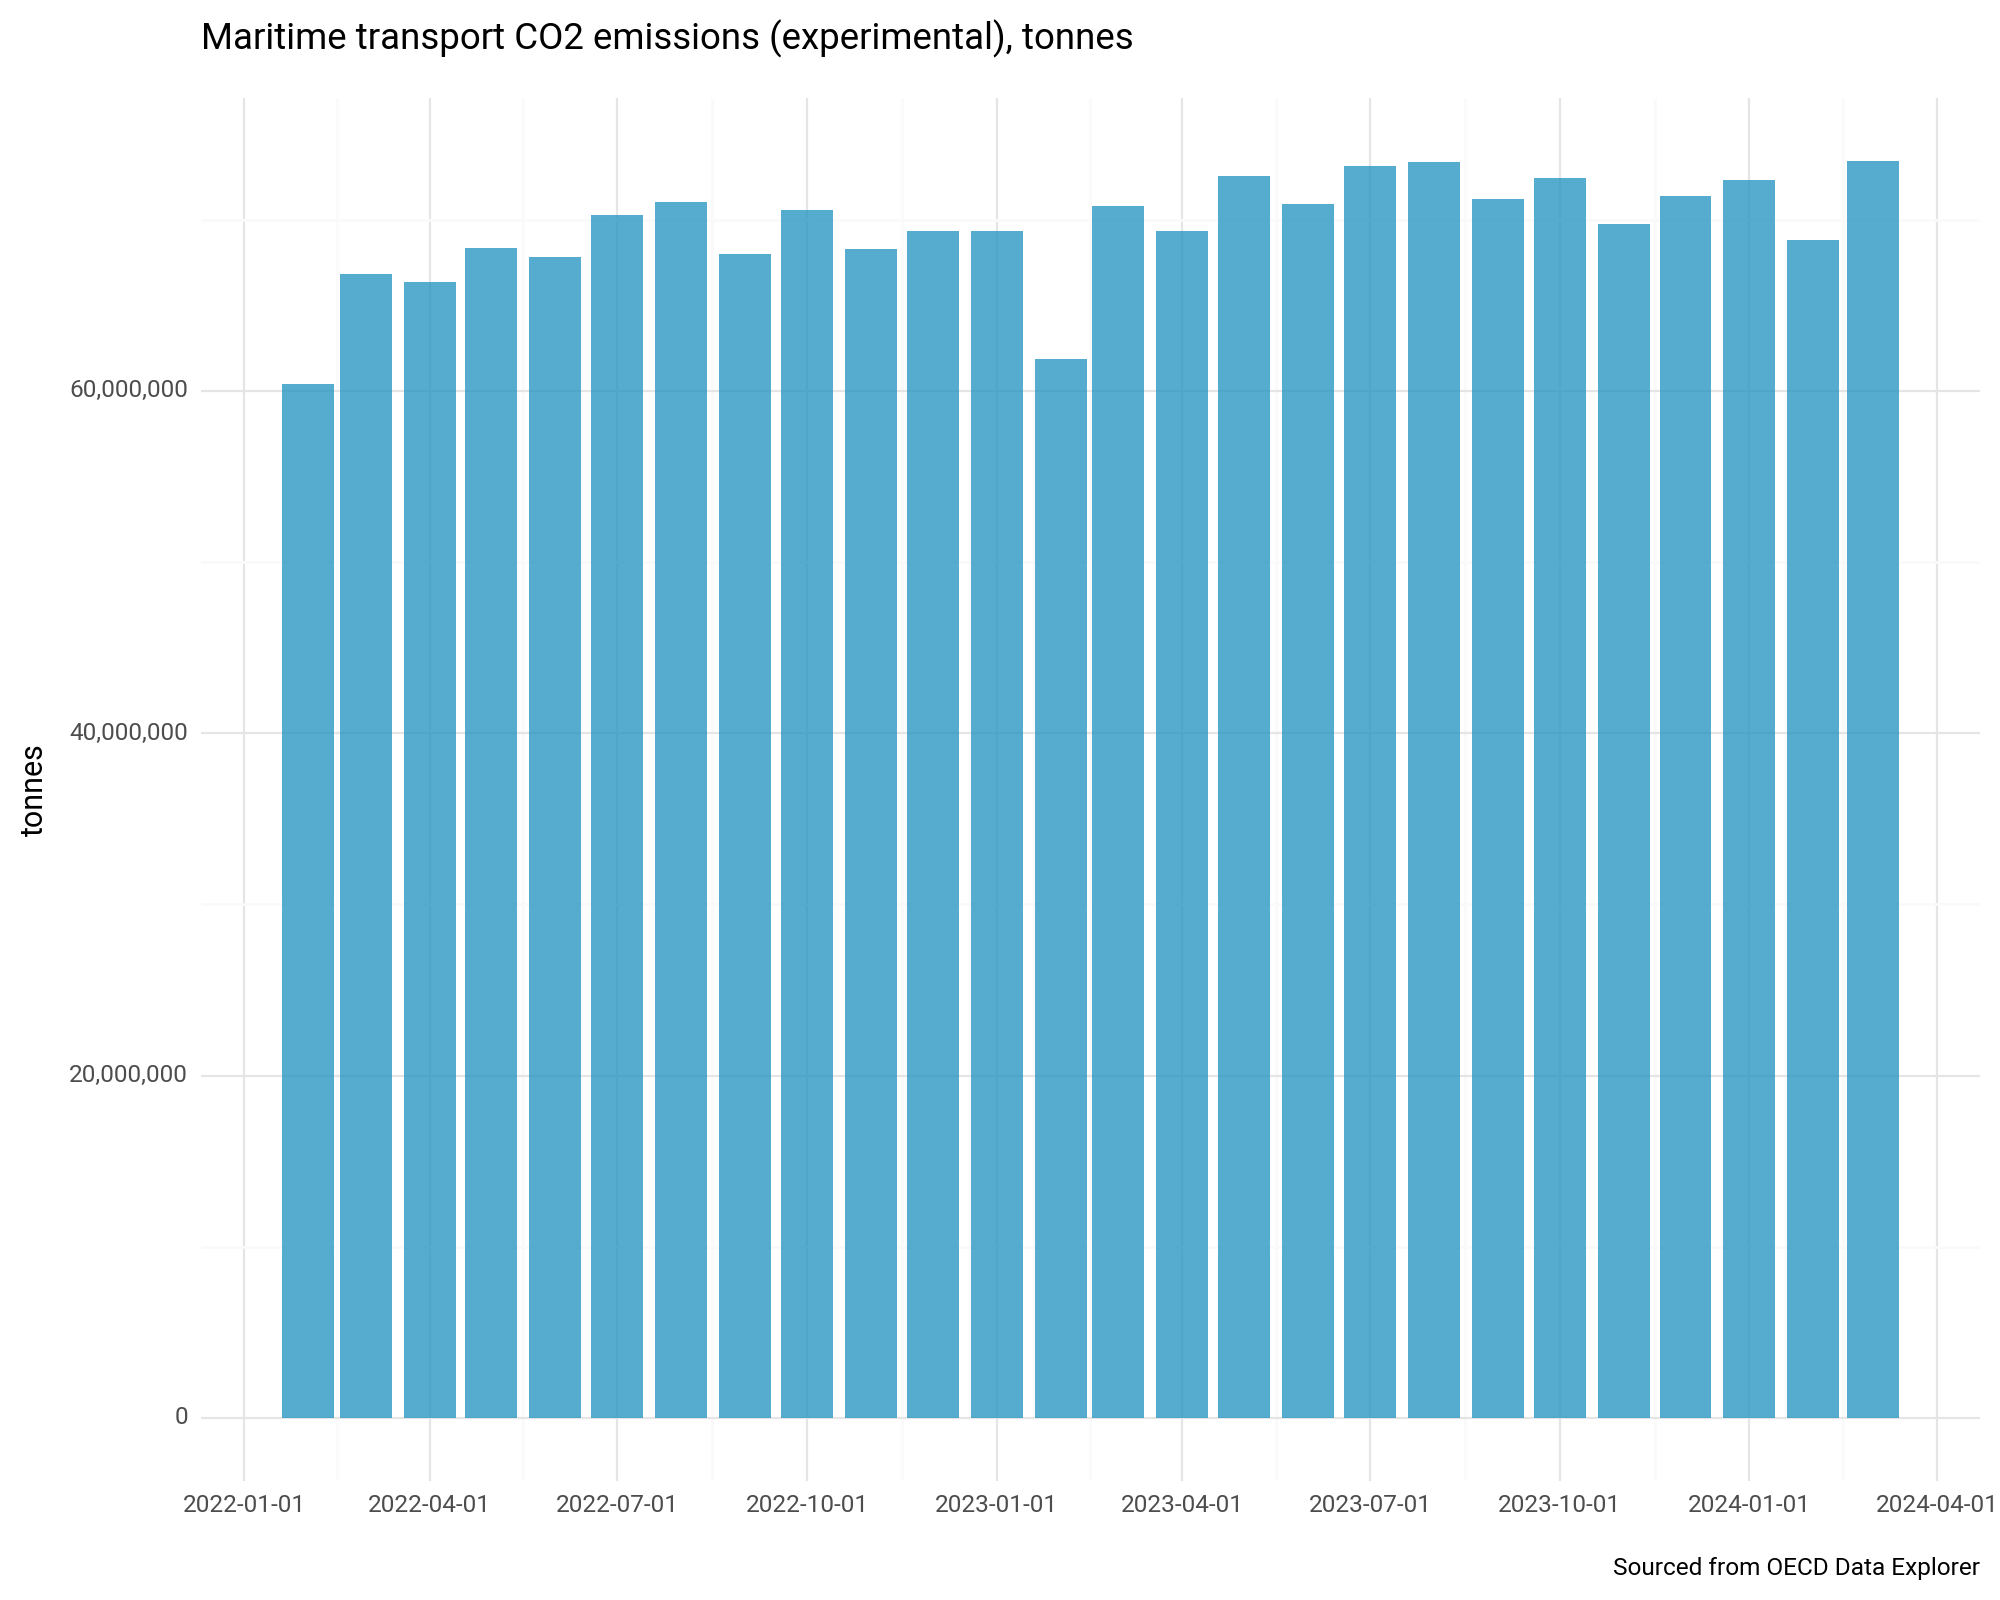

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\oecd-historical.jpeg


In [225]:
p0 = (
    ggplot(df, aes(x="ymd", y="OBS_VALUE"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        fill='#1d91c0'
        # width=0.5,
        # position="dodge2",
    )
    + labs(
        x="",
        y="tonnes",
        title=f"Maritime transport CO2 emissions (experimental), tonnes",
        caption="Sourced from OECD Data Explorer"
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p0)
p0.save(
    filename=join(charts_dir, 'routes', f"oecd-historical.jpeg"), dpi=300
)

In [210]:
df_filt = df.loc[df.ymd>"2023-01-01"].copy()

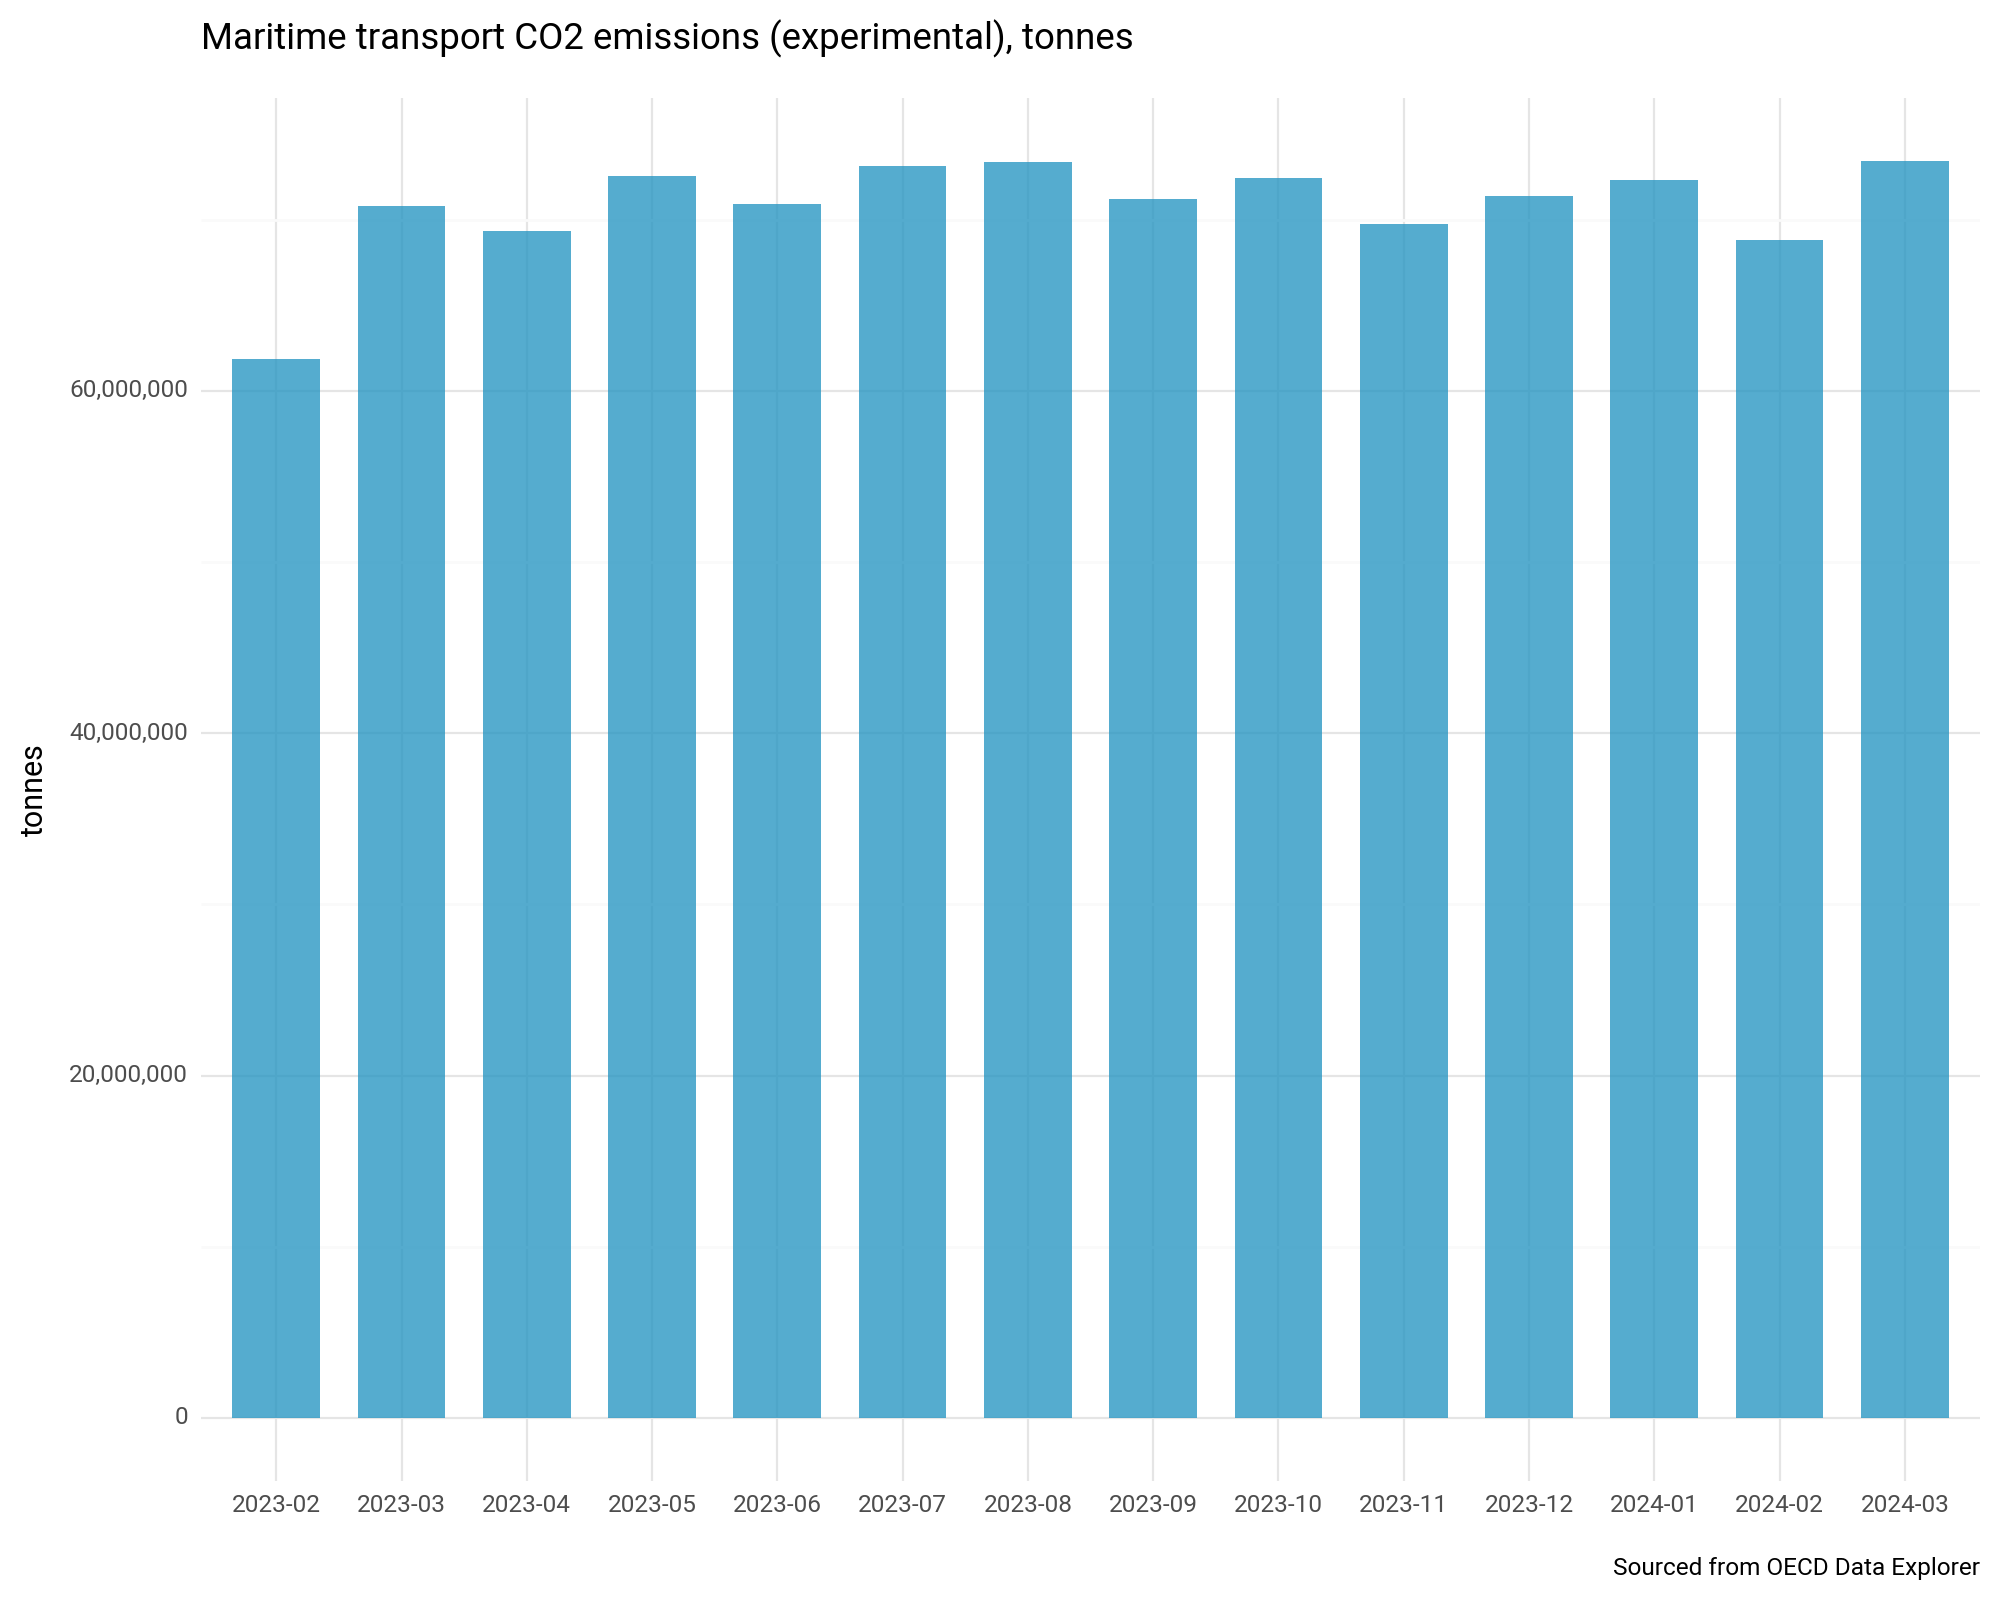

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\oecd.jpeg


In [223]:
p0 = (
    ggplot(df_filt, aes(x="year_month", y="OBS_VALUE"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        width=0.7,
        fill='#1d91c0'
        # position="dodge2",
    )
    + labs(
        x="",
        y="tonnes",
        title=f"Maritime transport CO2 emissions (experimental), tonnes",
        caption="Sourced from OECD Data Explorer"
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p0)
p0.save(
    filename=join(charts_dir, 'routes', f"oecd.jpeg"), dpi=300
)